# Synthesis: ICVL

In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import spectral as spy
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Image Loading

In [2]:
path = Path('datasets/ICVL-ENVI/eve_0331-1633.hdr')
envi = spy.io.envi.open(path)

In [3]:
wavelengths = np.array(envi.bands.centers)
wavelengths_mask = wavelengths <= 700
wavelengths = wavelengths[wavelengths_mask]

In [4]:
default_bands = list(map(int, envi.metadata['default bands']))

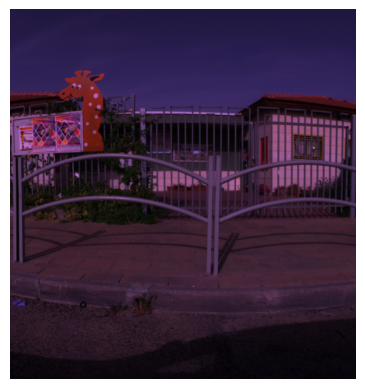

In [5]:
plt.axis('off')
plt.imshow(np.rot90(spy.get_rgb(envi, default_bands)))
plt.show()

## Illuminant Loading

In [6]:
d65_df = pd.read_csv('resources/illuminants/CIE_std_illum_D65.csv', header=None)
d65_w = d65_df[0].values
d65_i = d65_df[1].values

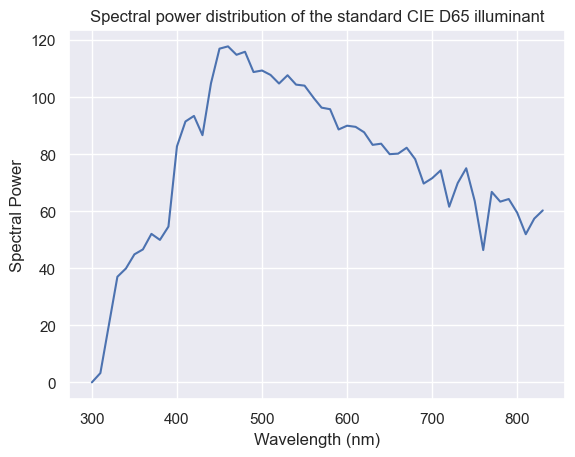

In [7]:
plt.title('Spectral power distribution of the standard CIE D65 illuminant')
plt.plot(d65_w, d65_i)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Power')
plt.show()

In [8]:
d65_i /= d65_i.max()
d65_i = interpolate.CubicSpline(d65_w, d65_i)(wavelengths)

In [9]:
illuminant = pd.read_csv(path.with_suffix('.csv'))
white = illuminant['White'].values[wavelengths_mask]
black = illuminant['Black'].values[wavelengths_mask]

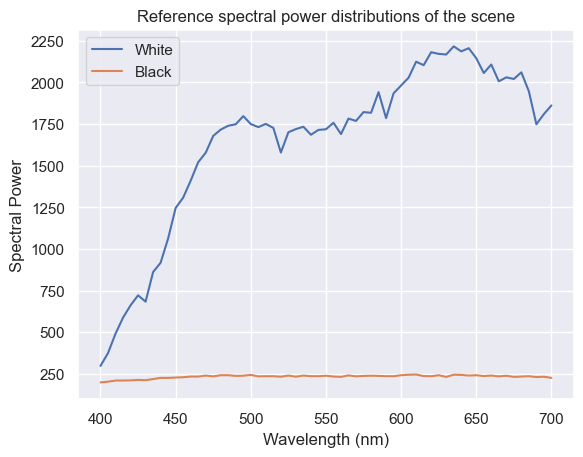

In [10]:
plt.title('Reference spectral power distributions of the scene')
plt.plot(wavelengths, white, label='White')
plt.plot(wavelengths, black, label='Black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Power')
plt.legend()
plt.show()

## Sensitivities: Sony IMX219

In [11]:
srf_df = pd.read_csv('resources/sensitivities/Sony_IMX219.csv')
srf_w = srf_df['Wavelength'].values
srf_r = srf_df['R'].values
srf_g = srf_df['G'].values
srf_b = srf_df['B'].values

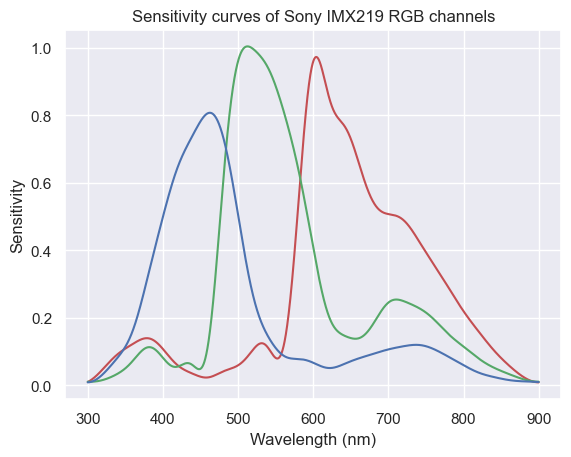

In [12]:
plt.title('Sensitivity curves of Sony IMX219 RGB channels')
plt.plot(srf_w, srf_r, color='r')
plt.plot(srf_w, srf_g, color='g')
plt.plot(srf_w, srf_b, color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [13]:
srf_r = interpolate.CubicSpline(srf_w, srf_r)(wavelengths)
srf_g = interpolate.CubicSpline(srf_w, srf_g)(wavelengths)
srf_b = interpolate.CubicSpline(srf_w, srf_b)(wavelengths)

In [14]:
srf_r /= integrate.simpson(srf_r, wavelengths)
srf_g /= integrate.simpson(srf_g, wavelengths)
srf_b /= integrate.simpson(srf_b, wavelengths)

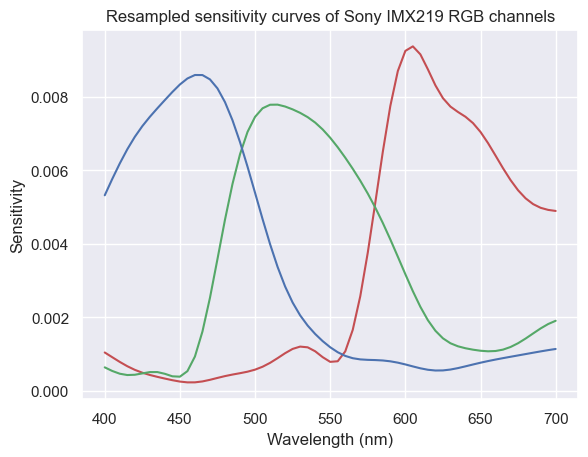

In [15]:
plt.title('Resampled sensitivity curves of Sony IMX219 RGB channels')
plt.plot(wavelengths, srf_r, color='r')
plt.plot(wavelengths, srf_g, color='g')
plt.plot(wavelengths, srf_b, color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [16]:
# Normalized by the bit depth.
srf_rgb_bd = np.zeros((envi.nrows, envi.ncols, 3))

for row in tqdm(range(envi.nrows)):
    spectra = envi.read_subregion((row, row + 1), (0, envi.ncols)).astype(np.float64)
    spectra = spectra[:, :, wavelengths_mask] / 4095.0

    srf_rgb_bd[row, :, 0] = integrate.simpson(spectra * srf_r, wavelengths)
    srf_rgb_bd[row, :, 1] = integrate.simpson(spectra * srf_g, wavelengths)
    srf_rgb_bd[row, :, 2] = integrate.simpson(spectra * srf_b, wavelengths)

srf_rgb_bd[srf_rgb_bd < 0] = 0
srf_rgb_bd[srf_rgb_bd > 1] = 1

100%|██████████| 1301/1301 [00:01<00:00, 778.61it/s]


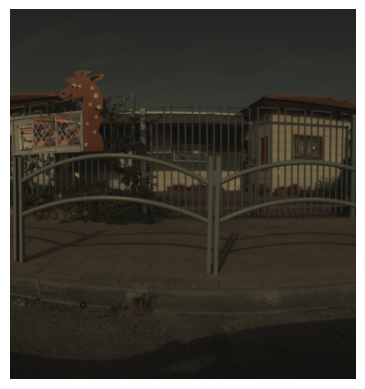

In [17]:
plt.axis('off')
plt.imshow(np.rot90(srf_rgb_bd))
plt.show()

In [18]:
# Normalized by illuminant (white balance).
srf_rgb_wb = np.zeros((envi.nrows, envi.ncols, 3))

for row in tqdm(range(envi.nrows)):
    spectra = envi.read_subregion((row, row + 1), (0, envi.ncols))
    spectra = spectra[:, :, wavelengths_mask]
    spectra = (spectra - black) / (white - black)

    srf_rgb_wb[row, :, 0] = integrate.simpson(spectra * srf_r, wavelengths)
    srf_rgb_wb[row, :, 1] = integrate.simpson(spectra * srf_g, wavelengths)
    srf_rgb_wb[row, :, 2] = integrate.simpson(spectra * srf_b, wavelengths)

srf_rgb_wb[srf_rgb_wb < 0] = 0
srf_rgb_wb[srf_rgb_wb > 1] = 1

100%|██████████| 1301/1301 [00:01<00:00, 1013.59it/s]


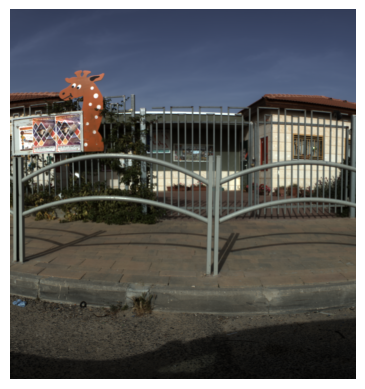

In [19]:
plt.axis('off')
plt.imshow(np.rot90(srf_rgb_wb))
plt.show()

## Sensitivities: CIE XYZ 1931

In [20]:
cie_df = pd.read_csv('resources/sensitivities/CIE_XYZ_1931.csv')
cie_w = cie_df['Wavelength'].values
cie_x = cie_df['X'].values
cie_y = cie_df['Y'].values
cie_z = cie_df['Z'].values

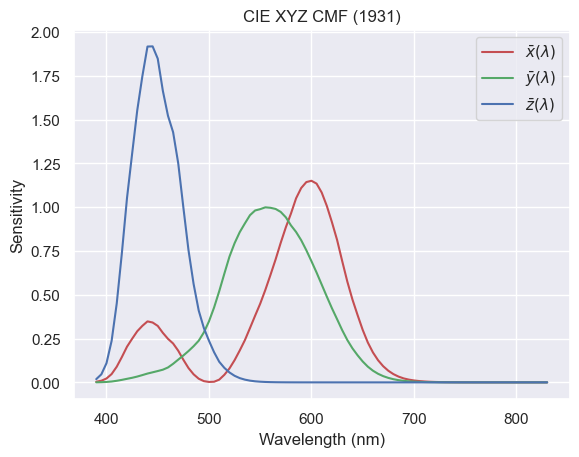

In [21]:
plt.title('CIE XYZ CMF (1931)')
plt.plot(cie_w, cie_x, color='r')
plt.plot(cie_w, cie_y, color='g')
plt.plot(cie_w, cie_z, color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [22]:
cie_x = interpolate.CubicSpline(cie_w, cie_x)(wavelengths)
cie_y = interpolate.CubicSpline(cie_w, cie_y)(wavelengths)
cie_z = interpolate.CubicSpline(cie_w, cie_z)(wavelengths)

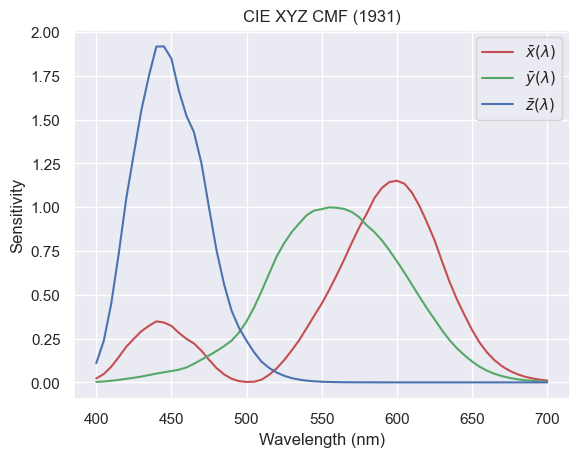

In [23]:
plt.title('CIE XYZ CMF (1931)')
plt.plot(wavelengths, cie_x, color='r')
plt.plot(wavelengths, cie_y, color='g')
plt.plot(wavelengths, cie_z, color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [24]:
k = integrate.simpson(d65_i * cie_y, wavelengths)
cie_x /= k
cie_y /= k
cie_z /= k

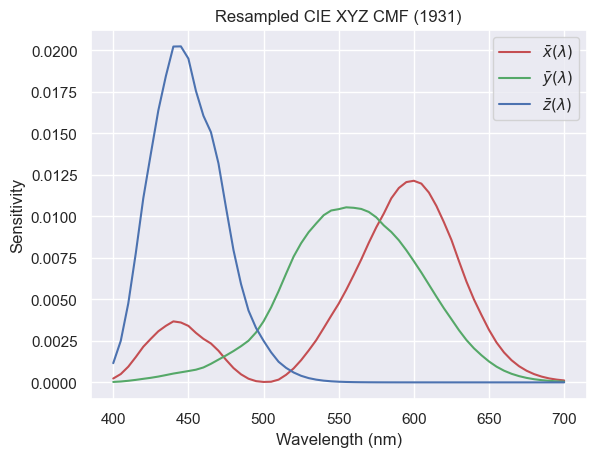

In [25]:
plt.title('Resampled CIE XYZ CMF (1931)')
plt.plot(wavelengths, cie_x, color='r')
plt.plot(wavelengths, cie_y, color='g')
plt.plot(wavelengths, cie_z, color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [26]:
cie_xyz = np.zeros((envi.nrows, envi.ncols, 3))

for row in tqdm(range(envi.nrows)):
    spectra = envi.read_subregion((row, row + 1), (0, envi.ncols))
    spectra = spectra[:, :, wavelengths_mask]
    spectra = (spectra - black) / (white - black)

    cie_xyz[row, :, 0] = integrate.simpson(spectra * cie_x * d65_i, wavelengths)
    cie_xyz[row, :, 1] = integrate.simpson(spectra * cie_y * d65_i, wavelengths)
    cie_xyz[row, :, 2] = integrate.simpson(spectra * cie_z * d65_i, wavelengths)

cie_xyz[cie_xyz < 0] = 0
cie_xyz[cie_xyz > 1] = 1

100%|██████████| 1301/1301 [00:01<00:00, 902.68it/s]


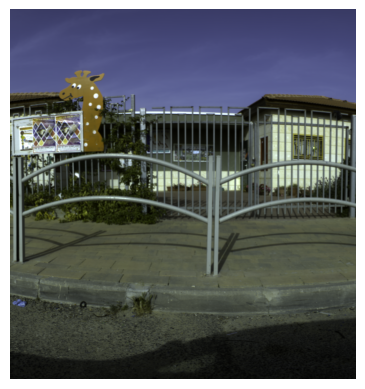

In [27]:
plt.axis('off')
plt.imshow(np.rot90(cie_xyz))
plt.show()

In [28]:
M = np.array([
    [+3.2404542, -1.5371385, -0.4985314],
    [-0.9692660, +1.8760108, +0.0415560],
    [+0.0556434, -0.2040259, +1.0572252],
])

In [29]:
cie_rgb = M @ cie_xyz.reshape(-1, 3).T
cie_rgb = cie_rgb.T.reshape(envi.nrows, envi.ncols, 3)

In [30]:
cie_rgb[cie_rgb < 0] = 0
cie_rgb[cie_rgb > 1] = 1

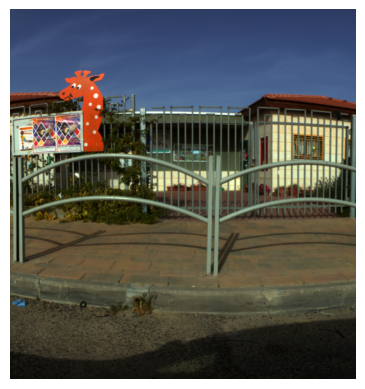

In [31]:
plt.axis('off')
plt.imshow(np.rot90(cie_rgb))
plt.show()

In [32]:
gamma_map = cie_rgb <= 0.0031308
cie_rgb[ gamma_map] = 12.92 * cie_rgb[ gamma_map]
cie_rgb[~gamma_map] = 1.055 * cie_rgb[~gamma_map]**0.416 - 0.055

In [33]:
cie_rgb[cie_rgb > 1] = 1
cie_rgb[cie_rgb < 0] = 0

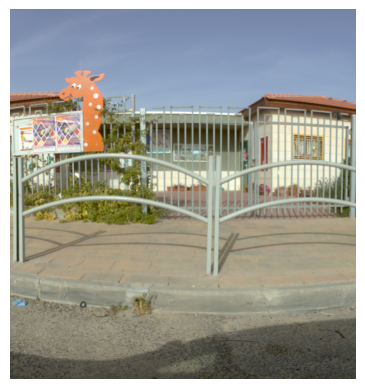

In [34]:
plt.axis('off')
plt.imshow(np.rot90(cie_rgb))
plt.show()